In [3]:
# importing libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm

# number of rows and columns to show
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)

# ensuring graphs properly display 
import matplotlib
%matplotlib inline

sns.set_style('ticks')

# Importing Data & Preprocessing --------------------------

In [4]:
dfml = pd.read_csv('Output/all_data_na.csv')
#dfml = pd.read_csv('Output/all_data_ml.csv')

In [5]:
dfml.shape

(831, 49)

In [6]:
print (len(dfml.Company_name.unique()))
print (len(dfml.loc[dfml['Year'] >= 2015].Company_name.unique()))

72
60


In [7]:
dfml.columns.sort_values()

Index(['A/R Turnover', 'Accounts Payable', 'Accounts Receivable',
       'Asset Turnover', 'Avg. A/R Days', 'Avg. Inventory Days',
       'Business_sector', 'CPI', 'Capital Expenditures', 'Cash Cycle(Days)',
       'Cash and ST Invest', 'Cash from OA', 'Changes in WC',
       'Company_MarketCap', 'Company_name', 'Consumer_confidence',
       'Consumer_spending', 'Cost of Revenue', 'Current Ratio', 'Debt/Equity',
       'Diluted EPS', 'Employment_rate', 'FCF', 'FY10', 'Full-Time Employees',
       'GDP', 'Gross Margin', 'Gross Profit', 'Industry', 'Industry_group',
       'Inv Turnover', 'Month', 'Net Income', 'Normalized EBIT',
       'Normalized EBITDA', 'Normalized EPS', 'PPE', 'Quarter', 'Quick Ratio',
       'Report_Date', 'Retail_group', 'Retail_sales', 'Retail_sales_index',
       'SGA Expenses', 'Timestamp', 'Total Inventory',
       'Total Operating Expense', 'Total Revenue', 'Year'],
      dtype='object')

In [8]:
dfml.dtypes.sort_values()

Year                         int64
Month                        int64
Quarter                      int64
Capital Expenditures       float64
Quick Ratio                float64
Current Ratio              float64
Cash Cycle(Days)           float64
A/R Turnover               float64
Avg. A/R Days              float64
Inv Turnover               float64
Avg. Inventory Days        float64
Debt/Equity                float64
GDP                        float64
Asset Turnover             float64
Consumer_confidence        float64
Consumer_spending          float64
CPI                        float64
Employment_rate            float64
Retail_sales               float64
Company_MarketCap          float64
Gross Margin               float64
Cash from OA               float64
Retail_sales_index         float64
FCF                        float64
Net Income                 float64
Normalized EBIT            float64
Normalized EBITDA          float64
Diluted EPS                float64
Cost of Revenue     

In [9]:
# Scaling
Numerical = np.array(dfml._get_numeric_data().iloc[:,3:44].values)
scaler_num = preprocessing.StandardScaler().fit(Numerical)
dfml._get_numeric_data().iloc[:,3:44] = scaler_num.transform(Numerical)   

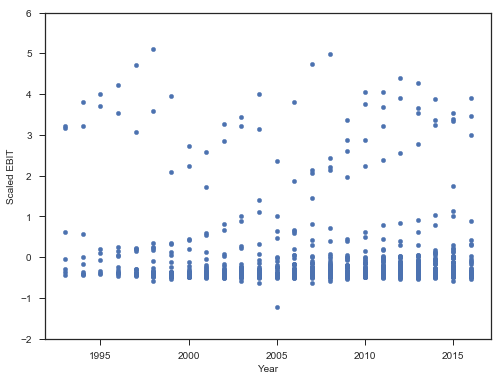

In [10]:
plt.rcParams["figure.figsize"] = [8,6]
dfml.plot(x="Year", y="Normalized EBIT", kind="scatter", ylim=(-2, 6))
plt.xlabel('Year', fontsize=10)
plt.ylabel('Scaled EBIT', fontsize=10)

In [11]:
# EBIT
dfml['EBIT'] = dfml['Normalized EBIT']
dfml['EBIT_t+1'] = dfml.groupby(['Company_name'])['Normalized EBIT'].transform(lambda x:x.shift(-1))
dfml['EBIT_t-1'] = dfml.groupby(['Company_name'])['Normalized EBIT'].transform(lambda x:x.shift(1))

In [12]:
# save as index
Company_name = dfml.Company_name

In [13]:
# convert the date to an ordinal i.e. an integer representing the number of days since year 1 day 1.
import datetime as dt
dfml['Timestamp'] = pd.to_datetime(dfml['Timestamp'], errors='raise')
dfml['Timestamp']=dfml['Timestamp'].map(dt.datetime.toordinal)

In [14]:
# laber encoder
#dfml = dfml.replace({'FY10' : {'Y' : 1, 'N' : 0}})
from sklearn import preprocessing 
lbl = preprocessing.LabelEncoder() 
lbl.fit(list(dfml['FY10'].values)) 
dfml['FY10'] = lbl.transform(list(dfml['FY10'].values))

In [15]:
# first method to split to training and test set 
# selec the last data point for each comp  
# indexlist
indexlist_test = dfml.dropna().groupby('Company_name').tail(1).copy()
indexlist_train = dfml.dropna().drop(dfml.dropna().groupby('Company_name').tail(1).index)

In [16]:
# drop unuseful column
dfml = dfml.drop(['Company_name','Normalized EBIT','Report_Date'], axis = 1)

In [17]:
# One hot encoding for remaining categorical features
dfml = pd.get_dummies(dfml)

In [18]:
dfml.Year.unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2014, 2015, 2012, 2013, 2016, 1998, 1999, 1996, 1997, 1993,
       1994, 1995])

In [19]:
# alternative method 
# split training and test set by date - test set only have 29 data points
#train = dfml[dfml['Year'] < 2015]
#test = dfml[dfml['Year'] >= 2015]

In [20]:
train = dfml.iloc[indexlist_train.index]
test = dfml.iloc[indexlist_test.index]

In [21]:
print('dfml:',dfml.dropna().shape)
print('train:',train.shape)
print('test:',test.shape)

dfml: (689, 98)
train: (624, 98)
test: (65, 98)


In [22]:
# X and y
train_y = train['EBIT_t+1']
train_x = train.drop(['EBIT_t+1'], axis =1)

In [23]:
test_y = test['EBIT_t+1']
test_x = test.drop(['EBIT_t+1'], axis =1)

In [24]:
print('train y:',train_y.shape)
print('test y:',test_y.shape)

train y: (624,)
test y: (65,)


train: (42,)
test: (3,)
train: (0,)
test: (0,)


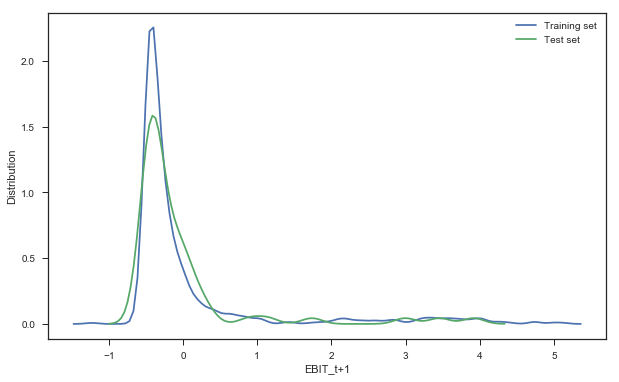

In [25]:
# check Outliers
plt.figure(figsize=(10,6))
test_column = 'EBIT_t+1'
ax1 = sns.kdeplot(train[test_column],label='Training set')
ax2 = sns.kdeplot(test[test_column],label='Test set')
ax1.set(xlabel='EBIT_t+1', ylabel='Distribution')
print ('train:', train[test_column][train[test_column] > 2.5].shape)
print ('test:', test[test_column][test[test_column] > 2.5].shape)
print ('train:', train[test_column][train[test_column] < -2].shape)
print ('test:', test[test_column][test[test_column] < -2].shape)

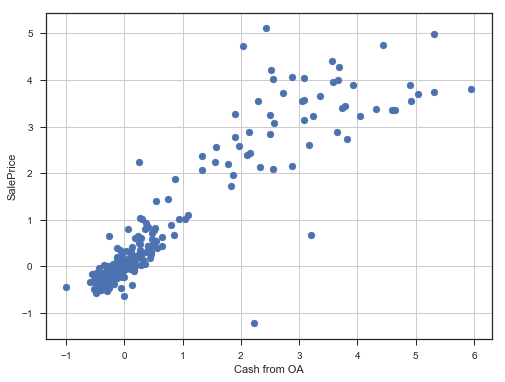

In [26]:
# Check data
c = 20
plt.scatter(train_x[train_x.columns[c]][:len(train_y)],train_y)
plt.xlabel(train_x.columns[c])
plt.ylabel("SalePrice")
plt.grid()
plt.show()
#X_new[X_new[X_new.columns[c]]>4000]

# Machine Learning ------------------------------------

In [27]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV

# Define a Performance Metric

In [28]:
# R2_score
def performance_metric(y_true, y_predict):
    score = r2_score(y_true, y_predict)
    return score

In [30]:
# RMSE of tain and test
n_folds = 5
def rmse_cv_train(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train_x, train_y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)
def rmse_cv_test(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, test_x, test_y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [31]:
# Another way
def RMSE(clf, train_x, train_y, k):
    while k <2:
        print("Please a number k bigger that 1 to perform a k-fold cross-validation")
        k = int(input())
    rmse = np.zeros(k)
    t = len(train_y)//k

    for j in range(k):

        x_cv = train_x[j*t:(j+1)*t]
        y_cv = train_y[j*t:(j+1)*t]

        x = train_x.drop(x_cv.index)
        y = train_y.drop(y_cv.index)

        clf.fit(x, y)
        mse = mean_squared_error(clf.predict(x_cv),y_cv)

        rmse[j] = np.sqrt(mse)
        
    Rmse = rmse.mean()

    return Rmse

# Feature selection ------------------------------------

# Linear Regression

In [32]:
from sklearn.linear_model import LinearRegression

In [33]:
# linear regression
lr = LinearRegression()
lr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [34]:
# Look at predictions on training and validation set
print("R2 on Training set :", lr.score(train_x,train_y))
print("R2 on Test set :", lr.score(test_x,test_y))

R2 on Training set : 0.952214705813
R2 on Test set : 0.826715587347


In [35]:
# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(train_x)
y_test_pred = lr.predict(test_x)

RMSE on Training set : 1.47700853215
RMSE on Test set : 0.596719024969


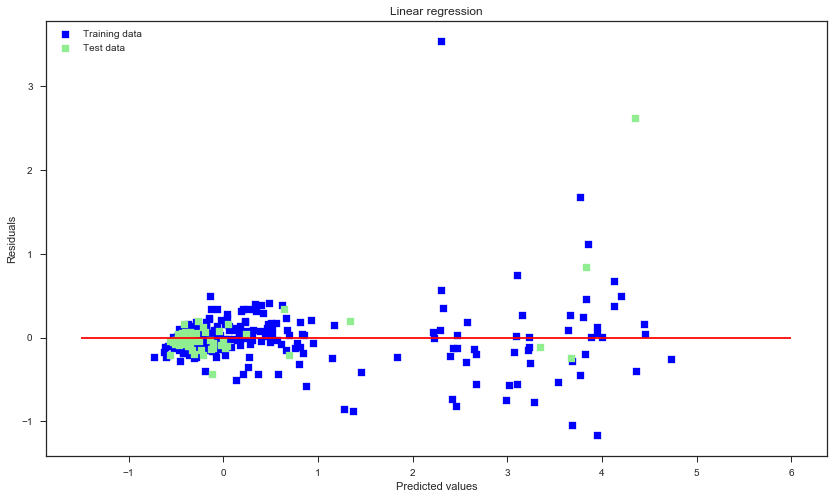

In [36]:
# Plot residuals
plt.rcParams["figure.figsize"] = [14,8]
plt.scatter(y_train_pred, y_train_pred - train_y, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - test_y, c = "lightgreen", marker = "s", label = "Test data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -1.5, xmax = 6, color = "red")
plt.show()

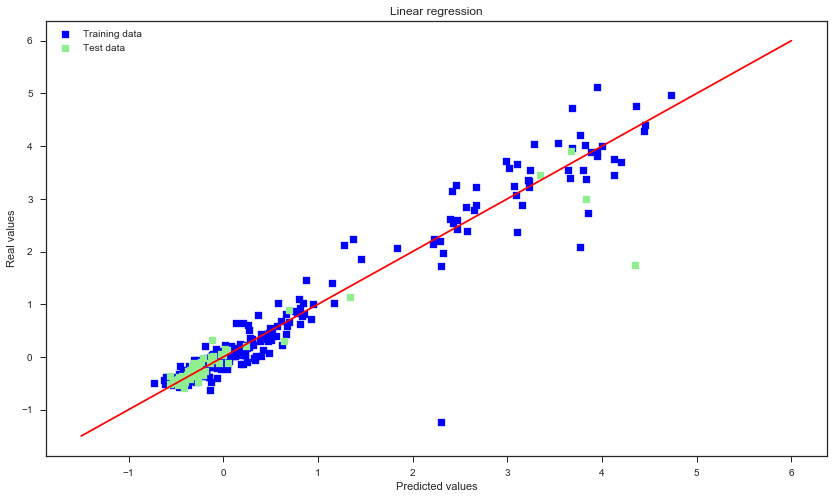

In [37]:
# Plot predictions
plt.scatter(y_train_pred, train_y, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, test_y, c = "lightgreen", marker = "s", label = "Test data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([-1.5, 6], [-1.5, 6], c = "red")
plt.show()

## Ridge Regression (L2 penalty)

In [47]:
from sklearn import linear_model
from sklearn.linear_model import Ridge, RidgeCV

In [39]:
# Ridge regression
ridge = RidgeCV(alphas = [0.1, 1, 10, 30, 60, 80, 100, 150, 200, 250, 300, 400, 600])
ridge.fit(train_x, train_y)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Best alpha : 30.0


In [57]:
# alpha = 30
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 60]
cv_ridge = [rmse_cv_train(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.min()

0.28218735318963323

In [40]:
ridge

RidgeCV(alphas=[0.1, 1, 10, 30, 60, 80, 100, 150, 200, 250, 300, 400, 600],
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [52]:
# cross validation
alphas = [i for i in range(1,100,1)]
v_ridge = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha = alpha,fit_intercept=True, normalize=False)
    v_ridge.append(RMSE(ridge, train_x, train_y, 5))

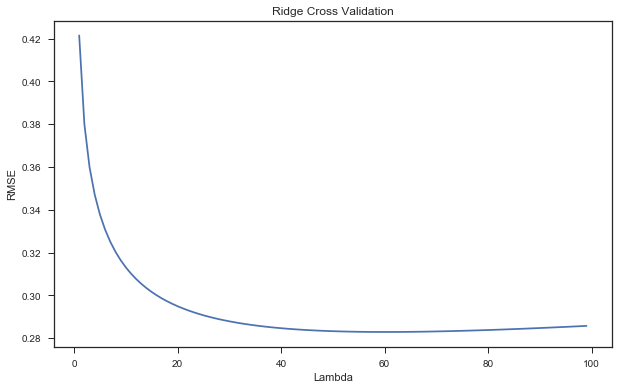

In [55]:
plt.figure(figsize=(10,6))
plt.plot(alphas,v_ridge)
plt.title("Ridge Cross Validation")
plt.ylabel("RMSE")
plt.xlabel("Lambda")
#plt.grid()
#plt.savefig("ridgeCV.pdf")
plt.show()

In [58]:
# Look at predictions on training and validation set
print("R2 on Training set :", ridge.score(train_x,train_y))
print("R2 on Test set :", ridge.score(test_x,test_y))

R2 on Training set : 0.940016816511
R2 on Test set : 0.865518919937


In [59]:
print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(train_x)
y_test_rdg = ridge.predict(test_x)

Ridge RMSE on Training set : 0.28486288607
Ridge RMSE on Test set : 0.314053385104


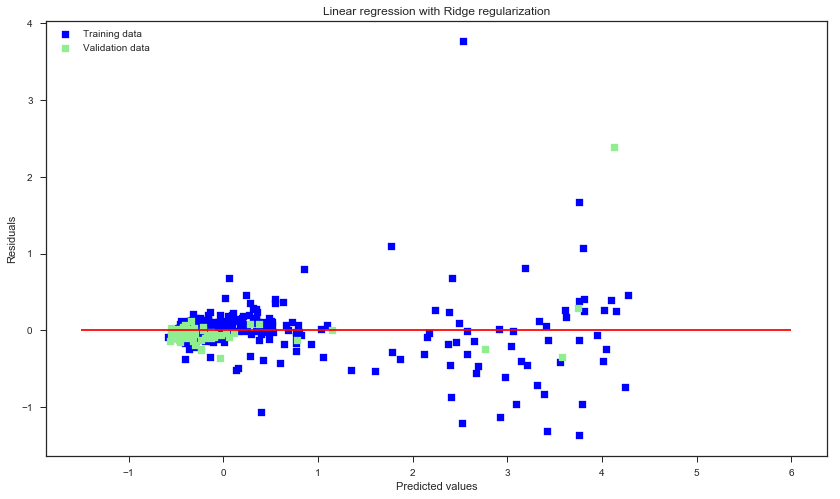

In [60]:
# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - train_y, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - test_y, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -1.5, xmax = 6, color = "red")
plt.show()

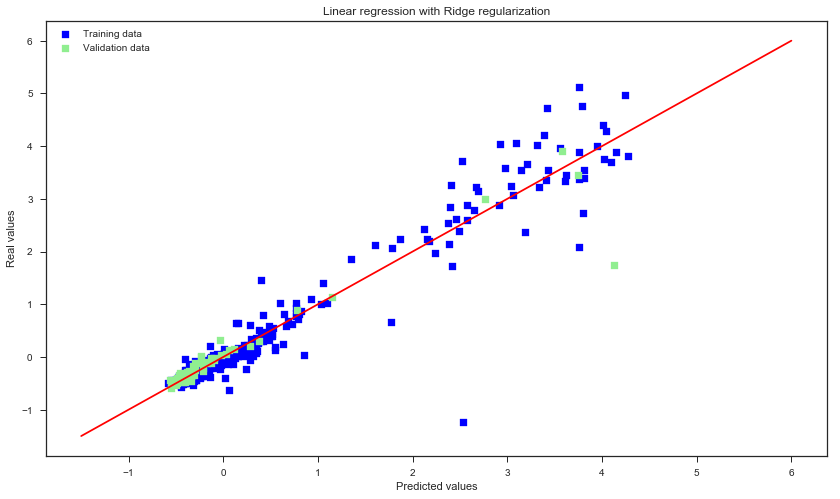

In [61]:
# Plot predictions
plt.scatter(y_train_rdg, train_y, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, test_y, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([-1.5, 6], [-1.5, 6], c = "red")
plt.show()

Ridge picked 83 features and eliminated the other 14 features


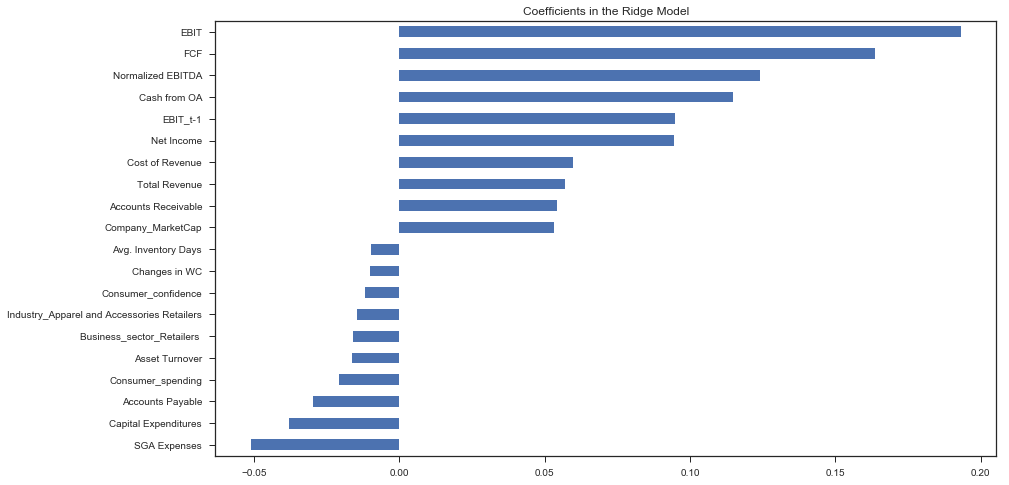

In [62]:
# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = train_x.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

In [63]:
ridlist = pd.DataFrame(coefs, columns=['Ridge'])

## Lasso Regression (L1 penalty)

In [64]:
from sklearn.linear_model import LassoCV, LassoLarsCV

In [65]:
# Lasso Regression
lasso = LassoCV(alphas = [0.006, 0.008, 0.009, 0.01, 0.03] ,
                max_iter = 200000, cv = 10)
lasso.fit(train_x, train_y)
alpha = lasso.alpha_
print("Best alpha :", alpha)

Best alpha : 0.03


In [66]:
# Look at predictions on training and validation set
print("R2 on Training set :", lasso.score(train_x,train_y))
print("R2 on Test set :", lasso.score(test_x,test_y))

R2 on Training set : 0.942109510447
R2 on Test set : 0.865363280308


In [95]:
print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(train_x)
y_test_las = lasso.predict(test_x)

Lasso RMSE on Training set : 0.277804077421
Lasso RMSE on Test set : 0.355588682864


In [101]:
from sklearn import linear_model
lambdas = [i/1000 for i in range(1,40,1)]
v_lasso = []
for lambd in lambdas:
    lasso = linear_model.Lasso(alpha = lambd,fit_intercept=True, normalize=False)
    v_lasso.append(RMSE(lasso, train_x, train_y, 5))

/Users/bakuna/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


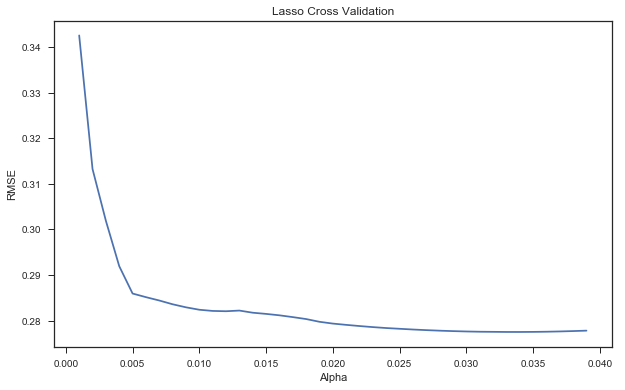

In [102]:
plt.figure(figsize=(10,6))
plt.plot(lambdas,v_lasso)
plt.title("Lasso Cross Validation")
plt.ylabel("RMSE")
plt.xlabel("Alpha")
#plt.grid()
#plt.savefig("lassoCV.pdf")
plt.show()

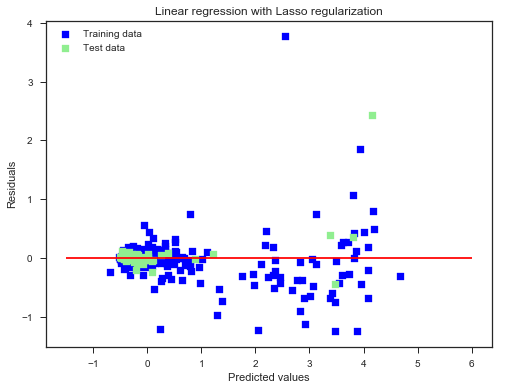

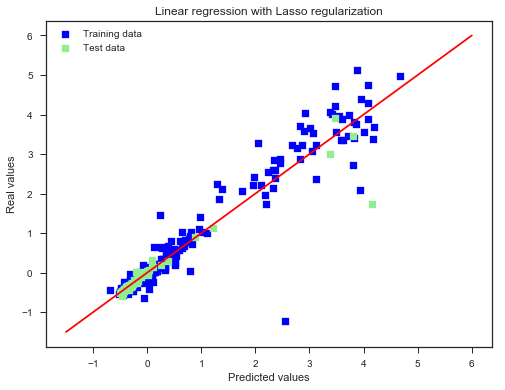

In [205]:
# Plot residuals
plt.scatter(y_train_las, y_train_las - train_y, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - test_y, c = "lightgreen", marker = "s", label = "Test data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -1.5, xmax = 6, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, train_y, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, test_y, c = "lightgreen", marker = "s", label = "Test data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([-1.5, 6], [-1.5, 6], c = "red")
plt.show()

Lasso picked 8 features and eliminated the other 89 features


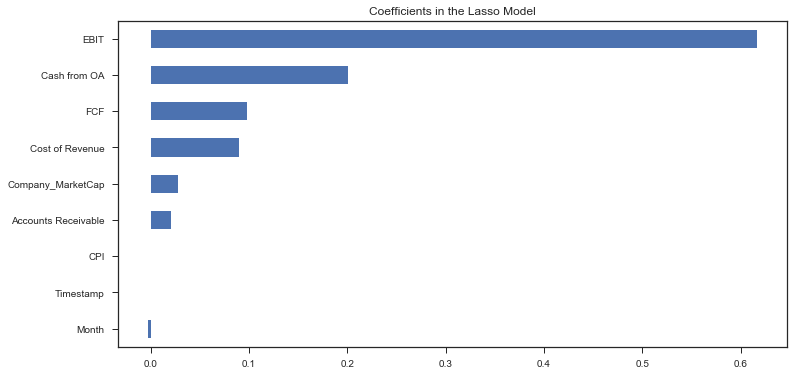

In [429]:
# Plot important coefficients
plt.figure(figsize=(12,6))
coefs = pd.Series(lasso.coef_, index = train_x.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(2),
                     coefs.sort_values().tail(7)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

## ElasticNet regularization (L1 and L2 penalty)

In [212]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

In [213]:
# ElasticNet
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [ 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(train_x, train_y)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

Best l1_ratio : 0.6
Best alpha : 0.03


In [214]:
elasticNet.score(train_x,train_y)

0.94310717612979422

In [215]:
elasticNet.score(test_x,test_y)

0.86342388195630537

In [224]:
print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())
y_train_ela = elasticNet.predict(train_x)
y_test_ela = elasticNet.predict(test_x)

ElasticNet RMSE on Training set : 0.27553174889
ElasticNet RMSE on Test set : 0.314235962115


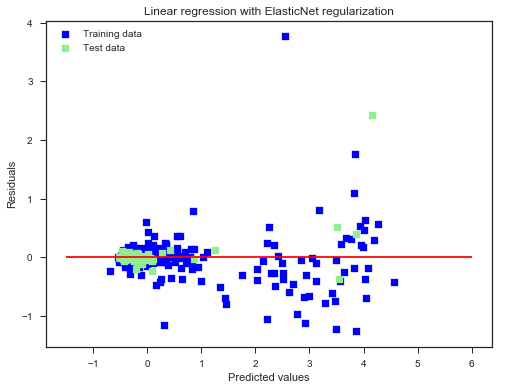

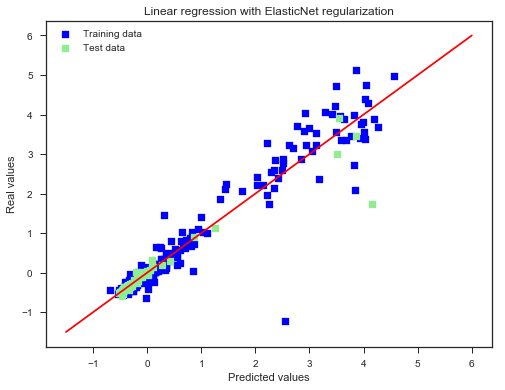

In [225]:
# Plot residuals
plt.scatter(y_train_ela, y_train_ela - train_y, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - test_y, c = "lightgreen", marker = "s", label = "Test data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = -1.5, xmax = 6, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_ela,train_y, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela,test_y, c = "lightgreen", marker = "s", label = "Test data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([-1.5, 6], [-1.5, 6], c = "red")
plt.show()

ElasticNet picked 12 features and eliminated the other 85 features


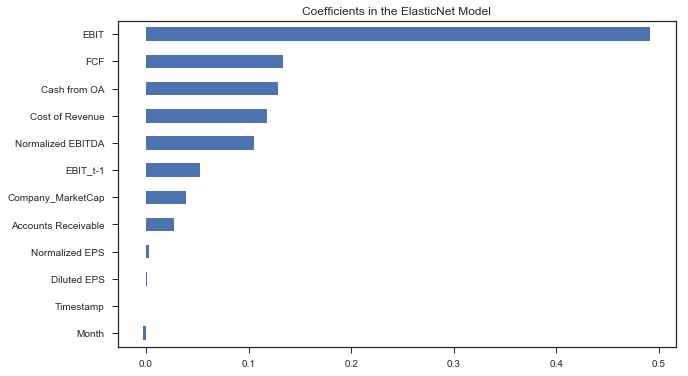

In [226]:
# Plot important coefficients
plt.figure(figsize=(10,6))
coefs = pd.Series(elasticNet.coef_, index = train_x.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(2),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

In [228]:
enlist = pd.DataFrame(coefs, columns=['ElasticNet'])

# Modelling ----------------------------------------

# CART Regression

# Decision Tree 

In [243]:
from sklearn import tree
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV

In [244]:
# Cross Validation Generator
cv = cross_validation.ShuffleSplit(len(train_x), n_iter=10, test_size=0.2,
    random_state=0)

In [245]:
#Perform parameter tunning
parameterTunning = True 

In [246]:
# Find the best parameters for DT
if(parameterTunning):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(
        train_x, train_y, test_size=0.3, random_state=0)

    tuned_parameters = [
        {'max_depth':[2, 10, 50, 100]},
        {'min_samples_leaf':[1, 2, 10, 50, 100]},
        {'min_samples_split':[2, 10, 50, 100]},
        {'presort':[True, False]},
        {'min_weight_fraction_leaf':[0.0, 0.1, 0.3]}]   

    #Grid Search for the Best Parameters
    clf = GridSearchCV(tree.DecisionTreeRegressor(), tuned_parameters, cv=10, scoring='r2')
    clf.fit(X_train, y_train)

    #best_estimator_ returns the best estimator chosen by the search
    print("Best parameters set found on development set:")
    print(clf.best_estimator_)
    print("")

    #Loop and print the results for each parameter
    print("Grid scores on training set:")
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))

Best parameters set found on development set:
DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

Grid scores on training set:
0.893 (+/-0.027) for {'max_depth': 2}
0.922 (+/-0.028) for {'max_depth': 10}
0.923 (+/-0.024) for {'max_depth': 50}
0.934 (+/-0.022) for {'max_depth': 100}
0.927 (+/-0.029) for {'min_samples_leaf': 1}
0.923 (+/-0.023) for {'min_samples_leaf': 2}
0.939 (+/-0.018) for {'min_samples_leaf': 10}
0.673 (+/-0.088) for {'min_samples_leaf': 50}
0.347 (+/-0.202) for {'min_samples_leaf': 100}
0.928 (+/-0.020) for {'min_samples_split': 2}
0.925 (+/-0.028) for {'min_samples_split': 10}
0.930 (+/-0.020) for {'min_samples_split': 50}
0.913 (+/-0.024) for {'min_samples_split': 100}
0.915 (+/-0.030) for {'presort': True}
0.924 (+/-0.029) for {'p

In [247]:
#Best Model Found by Parameter Tunning
dtr = tree.DecisionTreeRegressor(criterion='mse', max_depth=50, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=10,
           min_weight_fraction_leaf=0.0, presort=True, random_state=None,
           splitter='best')

In [248]:
# Cross Validation
print('10-Fold Crossvalidation | R-squared Coefficients')
for train, test in cv:
    clf = dtr.fit(train_x.iloc[train], train_y.iloc[train])
    print("train score: {0:.3f}, test score: {1:.3f}".format(
        clf.score(train_x.iloc[train], train_y.iloc[train]), clf.score(train_x.iloc[test], train_y.iloc[test])))

10-Fold Crossvalidation | R-squared Coefficients
train score: 0.949, test score: 0.891
train score: 0.951, test score: 0.906
train score: 0.973, test score: 0.729
train score: 0.949, test score: 0.916
train score: 0.939, test score: 0.951
train score: 0.946, test score: 0.931
train score: 0.944, test score: 0.940
train score: 0.946, test score: 0.953
train score: 0.948, test score: 0.892
train score: 0.952, test score: 0.902


In [249]:
# Predicting & Results
clf = dtr.fit(train_x, train_y)
print('R-squared Coefficient')
print("Train Score: {0:.7f} | Test Score: {1:.7f}".format(
        clf.score(train_x, train_y), clf.score(test_x, test_y)))

R-squared Coefficient
Train Score: 0.9561083 | Test Score: 0.9378690


In [250]:
# MSE
y_pred_dt = dtr.predict(test_x)
y_pred_dt_train = dtr.predict(train_x)

In [251]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, y_pred_dt)
mse_train = mean_squared_error(train_y, y_pred_dt_train)

In [252]:
mse

0.046545426210100355

In [253]:
# Calculate RMSE 
#import math
#math.sqrt(mse)
np.sqrt(((test_y - y_pred_dt) ** 2).mean())

0.21574389031928656

In [254]:
np.sqrt(((train_y - y_pred_dt_train) ** 2).mean())

0.22363088992172184

In [255]:
# R2
from sklearn import metrics
print('R2 score: %s' % metrics.r2_score(y_pred_dt, test_y))

R2 score: 0.942296838397


In [256]:
# learning curves
# Find the error for DTRs with max_depth between 1 and 60
from sklearn import cross_validation as cv
errors = []
for depth in range(1,61):
    scores = cv.cross_val_score(DecisionTreeRegressor(max_depth=depth,random_state=1),train_x,train_y,scoring='neg_mean_squared_error',cv=3)
    current_error = np.mean(np.sqrt(-scores))
    errors.append(current_error)

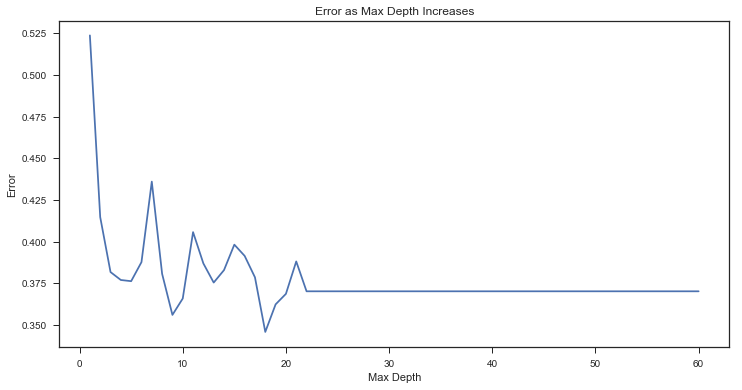

In [257]:
# Plot the errors to find our optimal value for max_depth
plt.figure(figsize=(12,6))
plt.plot(range(1,61),errors)
plt.xlabel('Max Depth')
plt.ylabel('Error')
plt.title('Error as Max Depth Increases')

<function matplotlib.pyplot.show>

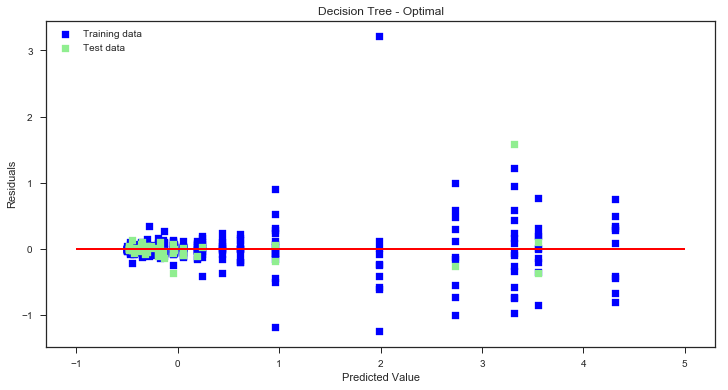

In [259]:
# residual plots
plt.figure(figsize=(12,6))
plt.scatter(y_pred_dt_train, y_pred_dt_train - train_y, c = 'blue', marker = 's', label = 'Training data')
plt.scatter(y_pred_dt, y_pred_dt - test_y, c = 'lightgreen', marker = 's', label = 'Test data')
plt.xlabel ('Predicted Value')
plt.ylabel ('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -1, xmax = 5, lw =2, color = 'red')
#plt.xlim([10, 15])
plt.title('Decision Tree - Optimal')
plt.show

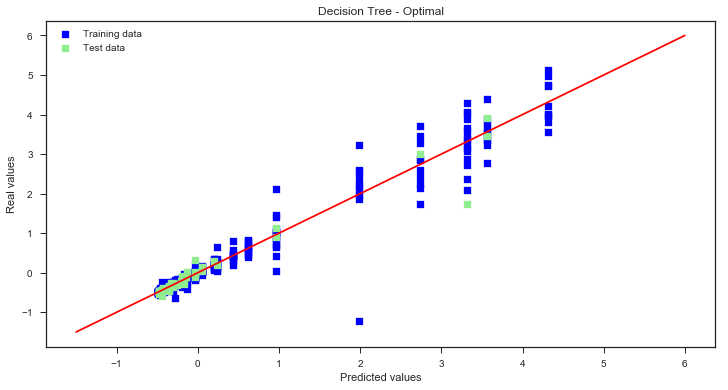

In [166]:
# Plot predictions
plt.figure(figsize=(12,6))
plt.scatter(y_pred_dt_train, train_y, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred_dt,test_y, c = "lightgreen", marker = "s", label = "Test data")
plt.title("Decision Tree - Optimal")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([-1.5, 6], [-1.5, 6], c = "red")
plt.show()

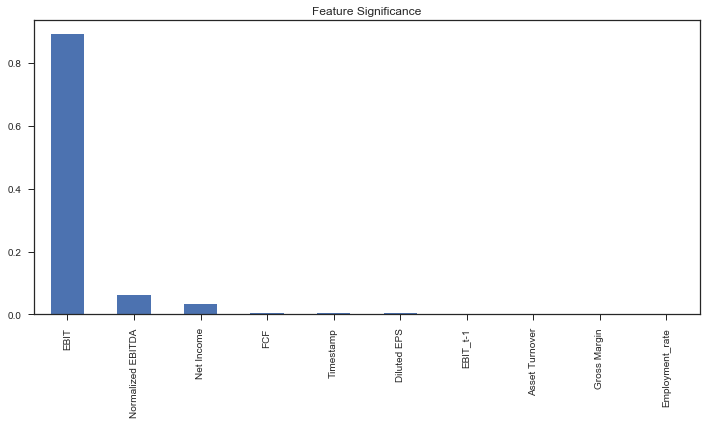

In [260]:
# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(dtr.feature_importances_, index = train_x.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
coef.head(10).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()

In [261]:
drtlist = pd.DataFrame(coef, columns=['Decision Tree'])

## Random Forest

In [67]:
from sklearn.ensemble import RandomForestRegressor

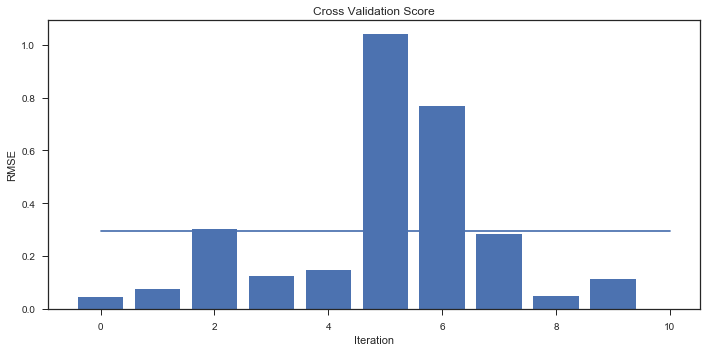

In [68]:
from sklearn.metrics import make_scorer, mean_squared_error
scorer = make_scorer(mean_squared_error, False)

clf = RandomForestRegressor(n_estimators=20, n_jobs=-1)
cv_score = np.sqrt(-cross_val_score(estimator=clf, X=train_x, y=train_y, cv=10, scoring = scorer))

plt.figure(figsize=(10,5))
plt.bar(range(len(cv_score)), cv_score)
plt.title('Cross Validation Score')
plt.ylabel('RMSE')
plt.xlabel('Iteration')

plt.plot(range(len(cv_score) + 1), [cv_score.mean()] * (len(cv_score) + 1))
plt.tight_layout()

In [69]:
# RMSE
cv_score.mean()

0.29507509872199056

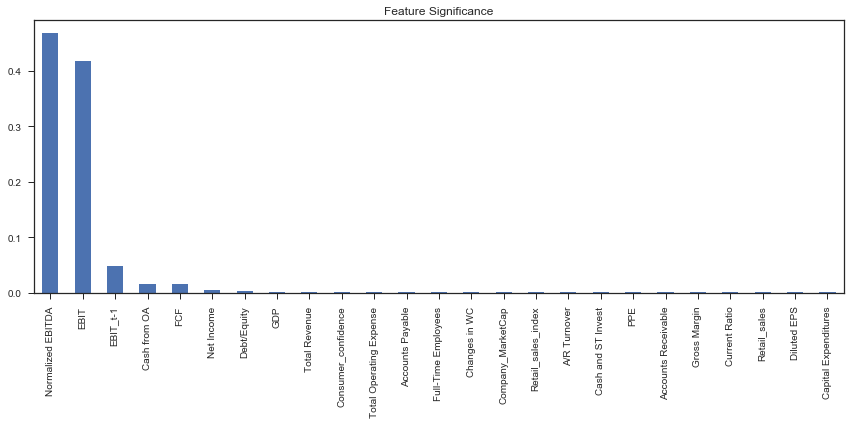

In [70]:
# Fit model with training data
clf.fit(train_x, train_y)

# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(clf.feature_importances_, index = train_x.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
coef.head(25).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()

In [71]:
# using GridSearchCV to find the optimal parameters
forest = RandomForestRegressor()   
parameters = {'n_estimators': np.arange(5, 50, 1)}       
forest_optimal = GridSearchCV(estimator = forest, param_grid = parameters, scoring = 'neg_mean_squared_error')
    
forest_optimal = forest_optimal.fit(train_x, train_y)

print ("Final model has an optimal max_depth parameter of", forest_optimal.best_params_)

Final model has an optimal max_depth parameter of {'n_estimators': 6}


In [72]:
forest

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [73]:
# Optimal model
forest = RandomForestRegressor(n_estimators = 6)

In [74]:
# R2
clf = forest.fit(train_x, train_y)
print('R-squared Coefficient')
print("Train Score: {0:.7f} | Test Score: {1:.7f}".format(
        clf.score(train_x, train_y), clf.score(test_x, test_y)))

R-squared Coefficient
Train Score: 0.9826664 | Test Score: 0.8698687


In [181]:
y_pred_rf = forest.predict(test_x)
y_pred_rf_train = forest.predict(train_x)

In [182]:
mse = mean_squared_error(test_y, y_pred_rf)
mse_train = mean_squared_error(train_y, y_pred_rf_train)

In [184]:
# Calculate RMSE 
np.sqrt(((test_y - y_pred_rf) ** 2).mean())

0.30929668729352483

In [183]:
np.sqrt(((train_y - y_pred_rf_train) ** 2).mean())

0.16413253903186484

<function matplotlib.pyplot.show>

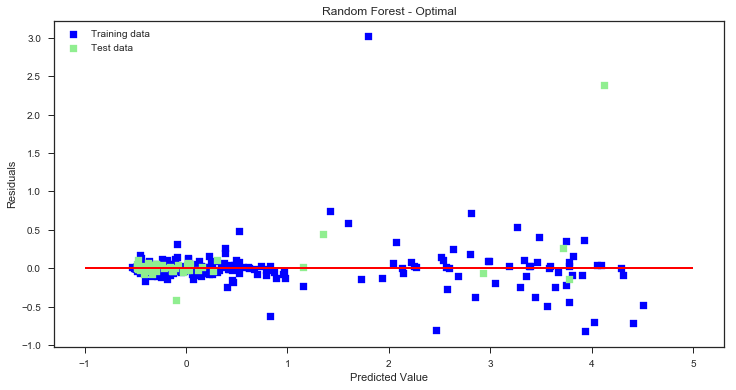

In [185]:
plt.figure(figsize=(12,6))
plt.scatter(y_pred_rf_train, y_pred_rf_train - train_y, c = 'blue', marker = 's', label = 'Training data')
plt.scatter(y_pred_rf, y_pred_rf - test_y, c = 'lightgreen', marker = 's', label = 'Test data')
plt.xlabel ('Predicted Value')
plt.ylabel ('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -1, xmax = 5, lw =2, color = 'red')
#plt.xlim([10, 15])
plt.title('Random Forest - Optimal')
plt.show

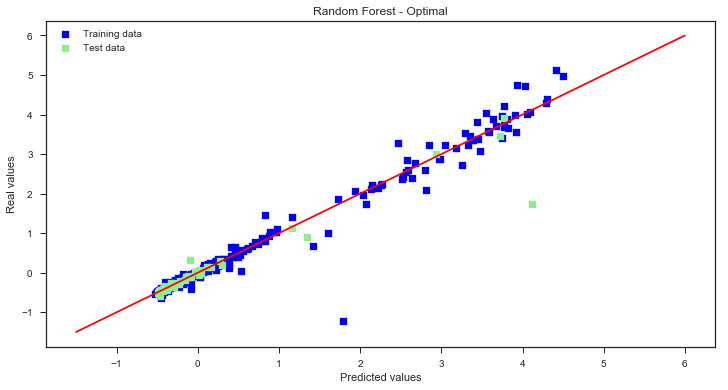

In [187]:
# Plot predictions
plt.figure(figsize=(12,6))
plt.scatter(y_pred_rf_train, train_y, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred_rf,test_y, c = "lightgreen", marker = "s", label = "Test data")
plt.title("Random Forest - Optimal")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([-1.5, 6], [-1.5, 6], c = "red")
plt.show()

In [196]:
rflist = pd.DataFrame(coef,columns=['random_forest'])

# SVR (RBF kernel)

## All Features

In [40]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

In [41]:
# base model
svr_rbf = SVR(kernel='rbf', C=0.1, gamma=0.1, epsilon=0.2)
svr_rbf.fit(train_x, train_y)

SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [42]:
# R2
clf = svr_rbf.fit(train_x, train_y)
print('R-squared Coefficient')
print("Train Score: {0:.3f} | Test Score: {1:.3f}".format(
        clf.score(train_x, train_y), clf.score(test_x, test_y)))

R-squared Coefficient
Train Score: 0.021 | Test Score: -0.031


In [51]:
# RMSE
print("SVR RMSE on Training set :", rmse_cv_train(svr_rbf).mean())
print("SVR RMSE on Test set :", rmse_cv_test(svr_rbf).mean())
y_train_svrb = svr_rbf.predict(train_x)
y_test_svrb = svr_rbf.predict(test_x)

SVR RMSE on Training set : 0.912336765966
SVR RMSE on Test set : 0.773496926288


In [52]:
rbf_predict = svr_rbf.predict(test_x)

In [53]:
# R2 on prediction
from sklearn import metrics
print('R2 score: %s' % metrics.r2_score(rbf_predict, test_y))

R2 score: -8049.13305332


In [354]:
# Grid research
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3,1,3,6,10],
                               "gamma": [0.001,0.01,0.02,0.03,0.04,0.05,0.10,0.2,0.3,0.4,0.5]})

In [55]:
svr_optimal = svr.fit(train_x, train_y)
print('R-squared Coefficient')
print("Train Score: {0:.3f} | Test Score: {1:.3f}".format(
        svr_optimal.score(train_x, train_y), svr_optimal.score(test_x, test_y)))

R-squared Coefficient
Train Score: -0.009 | Test Score: -0.062


In [56]:
svr_optimal.best_params_

{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}

In [57]:
svr_predicted = svr_optimal.predict(test_x)

In [58]:
# Calculate RMSE 
np.sqrt(((test_y - svr_predicted) ** 2).mean())

0.89214022510254831

In [59]:
# R2
from sklearn import metrics
print('R2 score: %s' % metrics.r2_score(svr_predicted, test_y))

R2 score: -864.361650772


In [60]:
train_x.shape

(624, 97)

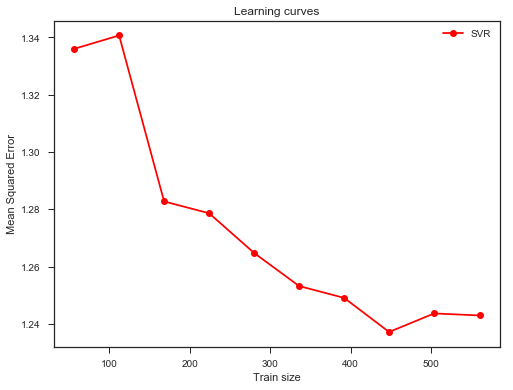

In [64]:
from sklearn.model_selection import learning_curve
plt.figure()

svr = SVR(kernel='rbf', C=0.1, gamma=0.01)
train_sizes, train_scores_svr, test_scores_svr = \
    learning_curve(svr, train_x[:624], train_y[:624], train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)

plt.plot(train_sizes, -test_scores_svr.mean(1), 'o-', color="r",
         label="SVR")

plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title('Learning curves')
plt.legend(loc="best")

plt.show()

## AdaBoost

In [334]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

svr_rbf = SVR(C=0.1, epsilon=0.2,gamma=0.01, kernel='rbf')
regr = AdaBoostRegressor(svr_rbf)

In [340]:
svr_ad = regr.fit(train_x, train_y)

In [342]:
svr_predicted = svr_ad.predict(test_x)

In [343]:
# Calculate RMSE 
np.sqrt(((test_y - svr_predicted) ** 2).mean())

0.87138401790349729

In [344]:
# R2
from sklearn import metrics
print('R2 score: %s' % metrics.r2_score(svr_predicted, test_y))

R2 score: -819.998746274


## SVR and Ridge 

In [355]:
train_x_rid = pd.DataFrame(train_x, columns=ridlist.loc[(ridlist!=0).any(axis=1)].index)
test_x_rid  = pd.DataFrame(test_x, columns=ridlist.loc[(ridlist!=0).any(axis=1)].index)

In [356]:
svr_rid = svr.fit(train_x_rid, train_y)

In [357]:
svr_rid.best_params_

{'C': 1.0, 'gamma': 0.01}

In [358]:
svr_predicted = svr_rid.predict(test_x_rid)

In [359]:
# Calculate RMSE 
np.sqrt(((test_y - svr_predicted) ** 2).mean())

0.85021204624820546

In [360]:
# R2
from sklearn import metrics
print('R2 score: %s' % metrics.r2_score(svr_predicted, test_y))

R2 score: -28.1981850606


## Elastic net

In [361]:
train_x_en = pd.DataFrame(train_x, columns=enlist.loc[(enlist!=0).any(axis=1)].index)
test_x_en  = pd.DataFrame(test_x, columns=enlist.loc[(enlist!=0).any(axis=1)].index)

In [362]:
svr_en = svr.fit(train_x_en, train_y)

In [363]:
svr_en.best_params_

{'C': 1.0, 'gamma': 0.04}

In [364]:
svr_predicted = svr_en.predict(test_x_en)

In [365]:
# Calculate RMSE 
np.sqrt(((test_y - svr_predicted) ** 2).mean())

0.85142609196413266

In [366]:
# R2
from sklearn import metrics
print('R2 score: %s' % metrics.r2_score(svr_predicted, test_y))

R2 score: -20.3804405961


## Decision tree

In [387]:
train_x_drt = pd.DataFrame(train_x, columns=drtlist.loc[(drtlist >0.001).any(axis=1)].index)
test_x_drt  = pd.DataFrame(test_x, columns=drtlist.loc[(drtlist>0.001).any(axis=1)].index)

In [388]:
svr_drt = svr.fit(train_x_drt, train_y)

In [389]:
svr_drt.best_params_

{'C': 1.0, 'gamma': 0.1}

In [390]:
svr_predicted = svr_en.predict(test_x_drt)

In [391]:
# R2
from sklearn import metrics
print('R2 score: %s' % metrics.r2_score(svr_predicted, test_y))

R2 score: -20.7669956878


In [392]:
# Calculate RMSE 
np.sqrt(((test_y - svr_predicted) ** 2).mean())

0.8486580231156674

## Random Forest

In [413]:
rflist.loc[(rflist>0.01).any(axis=1)]

,random_forest
EBIT,0.444458
Normalized EBITDA,0.386790
Net Income,0.043319
Cash from OA,0.039619
EBIT_t-1,0.037893
FCF,0.010745


In [406]:
train_x_rf = pd.DataFrame(train_x, columns=rflist.loc[(rflist>0.01).any(axis=1)].index)
test_x_rf  = pd.DataFrame(test_x, columns=rflist.loc[(rflist>0.01).any(axis=1)].index)

In [408]:
svr_rf = svr.fit(train_x_rf, train_y)

In [409]:
svr_rf.best_params_

{'C': 100.0, 'gamma': 0.001}

In [410]:
svr_predicted = svr_rf.predict(test_x_rf)

In [411]:
# R2
from sklearn import metrics
print('R2 score: %s' % metrics.r2_score(svr_predicted, test_y))

R2 score: 0.905193881249


In [412]:
# Calculate RMSE 
np.sqrt(((test_y - svr_predicted) ** 2).mean())

0.31573158648877742

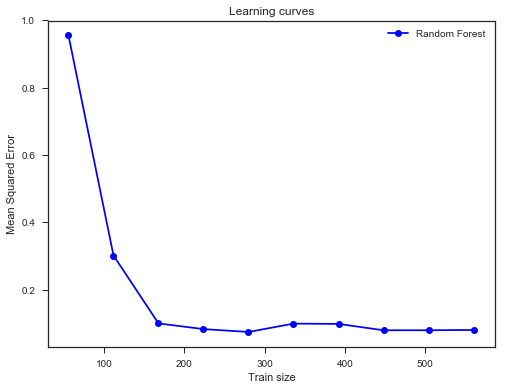

In [420]:
# learning curve
from sklearn.model_selection import learning_curve
plt.figure()

svr1 = SVR(kernel='rbf', C=100, gamma=0.001)
train_sizes1, train_scores_svr1, test_scores_svr1 = \
    learning_curve(svr1, train_x_rf[:624], train_y[:624], train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)

plt.plot(train_sizes1, -test_scores_svr1.mean(1), 'o-', color="b",
         label="Random Forest")

plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title('Learning curves')
plt.legend(loc="best")

plt.show()

# Save Predictions

In [89]:
# create a dataframe for the result
preds = pd.DataFrame()

In [90]:
dfml2 = pd.read_csv('Output/all_data_ml.csv')

In [87]:
#dfml2['Date'] = dfml2.groupby(['Company_name'])['Timestamp'].transform(lambda x:x.shift(-1))

In [91]:
preds['test_EBIT'] = test_y

In [92]:
preds['predicted'] = forest.predict(test_x)

In [97]:
preds['Date'] = dfml2.loc[preds['predicted'].index]['Report_Date']

In [98]:
preds['Company_name'] = dfml2.loc[preds['predicted'].index]['Company_name']

In [100]:
preds.shape

(65, 4)

In [101]:
from pandas import ExcelWriter
writer = ExcelWriter('preds.xlsx')
preds.to_excel(writer,'Sheet1')
writer.save()